In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import cv2
from tqdm import tqdm_notebook as tqdm

In [0]:
# path : /content/gdrive/My Drive/Datasets/Landscapes 
path = "/content/gdrive/My Drive/Datasets/Landscapes_snapshots"

In [0]:
%%capture
image_list = []
import os
for dirname, _, filename in tqdm(os.walk(path)) :
  for files in tqdm(filename) :
    i =  os.path.join(dirname, files)
    if i.endswith(".jpg") :
      image_list.append(i)

In [55]:
len(image_list)

4329

In [0]:
IMAGE_SIZE = (300, 300)
def load_image(image_path) : 
  image = cv2.imread(image_path) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (IMAGE_SIZE[0], IMAGE_SIZE[1]), interpolation = cv2.INTER_AREA)
  return image

def convert_lab(image) : 
  lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
  return lab_image[:,:,0]

def convert_rgb(image) : 
  rgb_image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
  return rgb_image
  
def plot_image(image) : 
  plt.figure(figsize = (20, 12))
  plt.imshow(image, cmap = "gray")
  plt.grid(False)

(300, 300, 3)


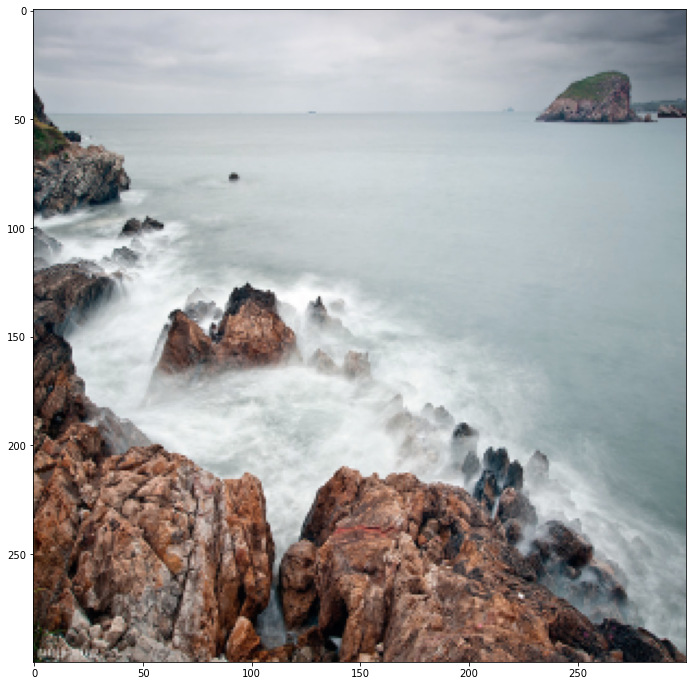

In [57]:
sample_image = load_image(image_list[3])
print(sample_image.shape)
plot_image(sample_image)

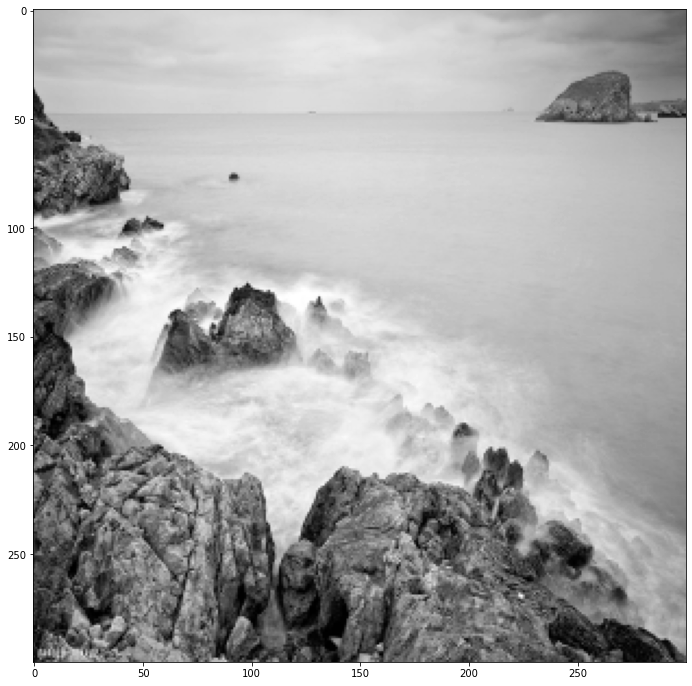

In [58]:
l = convert_lab(sample_image)
plot_image(l)

In [0]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 1
SPLIT_FACTOR = 0.85
EPOCHS = 4000

In [0]:
image_list = image_list[0:100]

In [64]:
l_images = []
target_images = []
for image_path in tqdm(image_list):
    image = load_image(image_path) 
    l_image = convert_lab(image)
    l_image = l_image.reshape(l_image.shape[0], l_image.shape[1], 1)    
    l_images.append(l_image)
    target_images.append(image[:, :, 1:])       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
l_images = np.array(l_images, dtype = np.float32)
l_images = l_images / 255.0

target_images = np.array(target_images, dtype = np.float32)
target_images = target_images/255.0

In [0]:
np.save("l_images", l_images)
np.save("target_images", target_images)

In [0]:
def prepare_dataset(split_factor) : 
  x_train, y_train = l_images[0:int(len(l_images) * split_factor)], target_images[0:int(len(target_images) * split_factor)]
  x_val, y_val = l_images[int(len(l_images) * split_factor) : ] , target_images[int(len(target_images) * split_factor) :]
  return x_train, y_train, x_val, y_val

In [0]:
x_train, y_train, x_val, y_val = prepare_dataset(SPLIT_FACTOR)

In [69]:
print("Shape of training set = ",x_train.shape, y_train.shape)
print("Shape of validation set = ",x_val.shape, y_val.shape)

Shape of training set =  (85, 300, 300, 1) (85, 300, 300, 2)
Shape of validation set =  (15, 300, 300, 1) (15, 300, 300, 2)


# Deep Learning Architecture - AutoEncoder 

In [0]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience = 25, restore_best_weights= False, verbose = True)

In [0]:
l_images = np.load("l_images.npy")
target_images = np.load("target_images.npy")

In [72]:
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
i = tf.keras.layers.Input(shape = input_shape)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size= (5,5), padding = "same", activation= "relu")(i)
x1 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (1,1), padding = "same", activation= "relu")(x)
x2 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x)
x2 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x)

x = tf.keras.layers.Add()([x2, x1])
x11 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (1,1), padding = "same", activation= "relu")(x)
x21 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x)
x21 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x21)

x = tf.keras.layers.Add()([x21, x11])
x11 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (1,1), padding = "same", activation= "relu")(x)
x21 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x)
x21 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x21)

x = tf.keras.layers.Add()([x21, x11])
x11 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (1,1), padding = "same", activation= "relu")(x)
x21 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x)
x21 = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(x21)

x = tf.keras.layers.Add()([x21, x11])

x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size= (3,3), padding = "same", activation ="relu")(x)
x = tf.keras.layers.Add()([x, x11])
x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size= (3,3), padding = "same", activation ="relu")(x)

x = tf.keras.layers.Add()([x, x1])
x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size= (3,3), padding = "same", activation ="relu")(x)

x = tf.keras.layers.Add()([x, x1])
x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size= (7,7), padding = "same", activation ="relu")(x)
x = tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size= (7,7), padding = "same", activation ="relu")(x)
x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size= (7,7), padding = "same", activation ="relu")(x)
x = tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size= (7,7), padding = "same", activation ="relu")(x)
x = tf.keras.layers.Conv2DTranspose(filters = 2, kernel_size= (7,7), padding = "same")(x)

model = tf.keras.models.Model(inputs = i, outputs = x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 1) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 300, 300, 128 3328        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 300, 300, 32) 36896       conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 300, 300, 32) 4128        conv2d_13[0][0]                  
____________________________________________________________________________________________

In [0]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001), loss = "MSE")

In [74]:
with tf.device("/device:GPU:0"):
  history = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = EPOCHS, verbose = 1, 
                      batch_size= BATCH_SIZE, callbacks = [reduce_lr, monitor_es], 
                      steps_per_epoch = np.ceil((len(x_train) / BATCH_SIZE)))      

Epoch 1/4000
85/85 [==============================] - 19s 218ms/step - loss: 0.1539 - val_loss: 0.0239 - lr: 0.0010
Epoch 2/4000
85/85 [==============================] - 18s 213ms/step - loss: 0.0253 - val_loss: 0.0241 - lr: 0.0010
Epoch 3/4000
85/85 [==============================] - 18s 214ms/step - loss: 0.0252 - val_loss: 0.0279 - lr: 0.0010
Epoch 4/4000
85/85 [==============================] - 18s 214ms/step - loss: 0.0227 - val_loss: 0.0378 - lr: 0.0010
Epoch 5/4000
85/85 [==============================] - 18s 214ms/step - loss: 0.0283 - val_loss: 0.0181 - lr: 0.0010
Epoch 6/4000
85/85 [==============================] - 18s 216ms/step - loss: 0.0218 - val_loss: 0.0215 - lr: 0.0010
Epoch 7/4000
85/85 [==============================] - 18s 214ms/step - loss: 0.0213 - val_loss: 0.0176 - lr: 0.0010
Epoch 8/4000
85/85 [==============================] - 18s 214ms/step - loss: 0.0176 - val_loss: 0.0168 - lr: 0.0010
Epoch 9/4000
85/85 [==============================] - 18s 213ms/step - l

In [0]:
plt.figure(1, figsize = (20, 12))           
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs, history.history["loss"], label = "Training Loss")
plt.plot(epochs, history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

In [0]:
"""
Saving model's topology
"""
model_json = model.to_json()
with open("coloring_autoencoder_model.json", "w") as json_file:
    json_file.write(model_json)

"""
Saving model's weights
"""
model.save_weights("coloring_autoencoder_model.h5")

In [75]:
loss = model.evaluate(x_val, y_val, batch_size = 1, verbose = 0)
loss = loss * 100
print("loss",loss) 

loss 1.3166707940399647


In [0]:
def result(image) : 
  sample_test = image
  output = model.predict(sample_test)
  output = (output * 255.0).astype(np.uint8)
  
  sample_test = (sample_test * 255.0).astype(np.uint8)
  
  colored_image = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  colored_image[:,:,0] = sample_test[:,:,0]
  colored_image[:,:,1:] = output[0]
  colored_image = colored_image.astype(np.uint8)
  
  sample_test = sample_test.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1])
  
  fig, axs= plt.subplots(1,2 , figsize = (20, 12))
  axs[0].imshow(sample_test, cmap = "gray")
  axs[0].axis(False)
 
  axs[1].imshow(convert_rgb(colored_image), cmap = "gray")
  axs[1].axis(False)

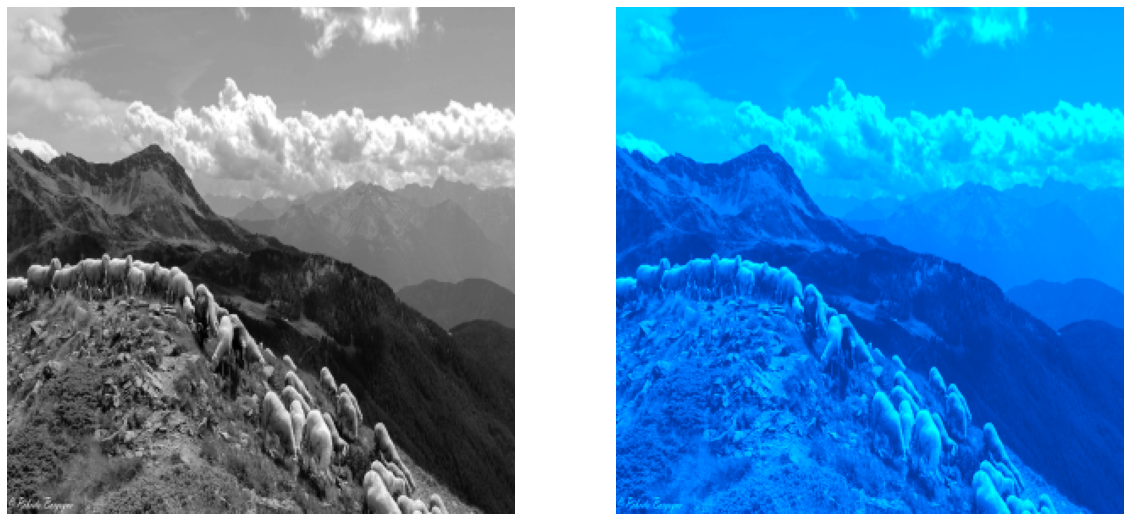

In [99]:
result(x_val[5])